In [72]:
import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as smf
import urllib.request
import zipfile

In [73]:
def get_fama_french():
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    
    # Download the file and save it  
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Extact the file data
    zip_file.extractall()
    zip_file.close()
    
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)
   
    # Skip null rows
    ff_row = ff_factors.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
    
    # Format dates to end of month
    ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

In [74]:
def get_momentum():
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
    
    # Download the file and save it  
    urllib.request.urlretrieve(url,'momentum.zip')
    zip_file = zipfile.ZipFile('momentum.zip', 'r')
    
    # Extact the file data
    zip_file.extractall()
    zip_file.close()
    
    momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)
   
    # Skip null rows
    row = momentum_factor.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)
    
    # Format the date index
    momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')
    
    # Format dates to end of month
    momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()
    
    # Convert from percent to decimal
    momentum_factor = momentum_factor.apply(lambda x: x/ 100)
    return momentum_factor

In [75]:
def get_return_data(price_data, period = "M"):
    
    # Resample the data to monthly price
    price = price_data.resample(period).last()
    
    # Calculate the percent change
    ret_data = price.pct_change()[1:]
    
    # Convert from series to dataframe
    ret_data = pd.DataFrame(ret_data)
    
    return ret_data

In [76]:
# def get_mu_Q(exRets, factor_data, regress_type="Linear"):

#     # Calculate the factor expected excess return from historical data using the geometric mean
#     gmean = stats.gmean(factor_data + 1,axis=0) - 1
#     n_factors = len(gmean)
 
#     # Calculate the factor covariance matrix
#     F = factor_data.cov()
    
#     # Set up X and Y to determine alpha and beta
#     factor_data['Ones'] = [1 for i in range(len(factor_data))]
#     X = factor_data
#     Y = exRets
#     X = X.to_numpy()
#     Y = Y.to_numpy()
    
#    # Determine alpha and beta
#     if regress_type == "Linear":
#         model = LinearRegression().fit(X,Y)
#     elif regress_type == "Lasso":
#         model = Lasso().fit(X,Y)
#     else:
#         model = Ridge().fit(X,Y)
#     alpha = model.intercept_
#     beta = model.coef_[:,0:n_factors]

#     # Calculate the residuals 
#     alpha = np.reshape(alpha,(alpha.size,1))
#     epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))
    
#     # Calculate the residual variance with "N - p - 1" degrees of freedom
#     p = 3
#     sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)
    
#     #  Calculate the asset expected excess returns
#     mu = model.predict([np.append(gmean,1)])[0]
    
#     # Calculate the diagonal matrix of residuals and the asset covariance matrix
#     D = np.diag(sigmaEp)
    
#     # Calculate the covariance matrix
#     Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

    
#     return mu, Q

In [77]:
# get_mu_Q(exRets, ff_data)

In [78]:
def get_mu_Q_multiperiod(exRets, factor_data, n_periods, regress_type="Linear"):
    """
    exRets: excess return data for stocks
    factor_data: factor return data
    n_periods: number of periods in the future to estimate
    regress_type: can be 'Linear', 'Lasso', or 'Ridge'
    """
    
    # For keeping track of mu's and Q's from each period
    mu_arr = []
    Q_arr = []
            
    n_factors = len(factor_data.columns)

    for i in range(0, n_periods):
        print(i)

        # Calculate the factor covariance matrix
        F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()
        
        # Calculate the factor expected excess return from historical data using the geometric mean
        factor_data['Ones'] = [1 for i in range(len(factor_data))]
        gmean = stats.gmean(factor_data + 1,axis=0) - 1

        # Set up X and Y to determine alpha and beta
        X = factor_data
        Y = exRets
        X = X.to_numpy()
        Y = Y.to_numpy()

       # Determine alpha and beta
        if regress_type=="Linear":
            model = LinearRegression().fit(X,Y)
        elif regress_type=="Lasso":
            model = Lasso().fit(X,Y)
        elif regress_type=="Ridge":
            model = Ridge().fit(X,Y)
        else:
            print("Error: This type of regression has not been implemented.")
        alpha = model.intercept_
        beta = model.coef_[:,0:n_factors]

        # Calculate the residuals 
        alpha = np.reshape(alpha,(alpha.size,1))
        epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

        # Calculate the residual variance with "N - p - 1" degrees of freedom
        p = 3
        sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)

        #  Calculate the asset expected excess returns
        mu = model.predict([gmean])[0]

        # Calculate the diagonal matrix of residuals and the asset covariance matrix
        D = np.diag(sigmaEp)

        # Calculate the covariance matrix
        Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D
        
        # Add mu and Q to array
        mu_arr.append(mu)
        Q_arr.append(Q)
        
        # Update for next time step
        factor_data = factor_data[1:]
        factor_append = pd.Series(gmean, index = factor_data.columns)
        factor_data.append(factor_append, ignore_index=True)
        
        exRets = exRets[1:]
        mu_append = pd.Series(mu, index=exRets.columns)
        exRets.append(mu_append, ignore_index=True)   
        
    return mu_arr, Q_arr

In [79]:
# def get_mu_Q_PCA(price_data, K):
#     # Calculate excess returns 
#     exRets = get_return_data(price_data)
    
#     meanRets = 
    
#     return mu, Q

In [80]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std

In [81]:
def portfolio_returns(weights, mean_returns, cov_matrix):
    return np.sum(mean_returns*weights ) *252

In [82]:
def min_variance(mean_returns, cov_matrix, target_return=0.1):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'eq', 'fun': lambda x: target_return - portfolio_returns(x, mean_returns, cov_matrix)})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [83]:
# Get price data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
price_data.index = pd.to_datetime(price_data.index)

In [84]:
'''Fama-French'''

ff_data = get_fama_french()
ff_data = ff_data.iloc[:,0:3] 

# Make dates consistent between price and factor data
exRets = get_return_data(price_data)
factor_last = ff_data.index[ff_data.shape[0] - 1].date()
exRets = exRets.loc[:factor_last]
price_first = exRets.index[0].date()
ff_data = ff_data.loc[price_first:]

mu, Q = get_mu_Q_multiperiod(exRets, ff_data,3, "Lasso")
print(mu)
print(Q)
#min_variance(mu,Q)

c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  app.launch_new_instance()
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1
2
[array([-4.39062157e-02,  6.53866223e-02,  4.89477489e-03,  1.68232574e-02,
        1.15138255e-02,  2.16164441e-02,  2.02354033e-02,  4.99166246e-02,
        6.55932101e-03,  1.31129463e-02, -1.42380384e-02,  4.33912542e-02,
       -4.91321176e-02, -1.18985297e-02,  1.17077292e-02, -2.63081626e-02,
       -2.85461803e-02, -2.58168684e-03,  1.48698174e-02,  1.51357654e-02,
        3.66185625e-02, -2.38582328e-02, -8.47650149e-04, -1.05036109e-02,
        1.12925726e-02,  1.38927537e-02,  9.56478348e-02,  1.10813511e-02,
        2.26337821e-02, -1.33673371e-02,  1.16655859e-02,  5.51087990e-02,
        3.34617417e-02,  1.12681851e-02,  7.14413663e-03,  4.41504349e-03,
        1.06863010e-01,  2.84888706e-02,  1.26439692e-02,  1.21921905e-02,
        5.06403840e-03,  3.55484846e-02, -2.56479813e-02,  2.55229025e-02,
        6.56072548e-03,  1.23935517e-02, -7.29586648e-03,  1.55451558e-02,
       -5.95926456e-03, -2.68167742e-03, -5.33345347e-02,  4.77000399e-02,
       -2.42874916

In [88]:
# # Run optimization for CAPM
# CAPM_data = ff_data.iloc[:,0:1] #first column of FF data is just market rf
# mu, Q = get_mu_Q(price_data, CAPM_data)
# min_variance(mu,Q)

In [89]:
# # Run optimization for Carhart (FF + momentum)
# momentum_factor = get_momentum()
# carhart_data = pd.concat([ff_data, momentum_factor], axis=1).dropna()
# mu, Q = get_mu_Q(price_data, carhart_data)
# min_variance(mu,Q)

In [87]:
def backtest(n_periods, len_period, start_date, exRets, predicted_mu, predicted_Q):
    stock_returns = exRets.loc[start_date:] 
    portfolio_returns = []
    for i in range(n_periods):
        #INSERT PREDICTED WEIGHTS, SHOULD BE 1D ARRAY (1 x number of stocks)
        #weights = INSERTMODELHERE(predicted_mu,predicted_Q)
        #DELETE LINE BELOW - JUST A PLACEHOLDER
        weights = [1/len(exRets.columns) for i in range(len(exRets.columns))]

        period_return = sum(weights*stock_returns.iloc[i*len_period])
        portfolio_returns.append(period_return)
    return portfolio_returns

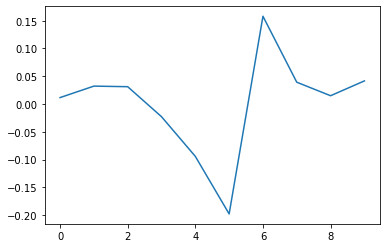

In [71]:
import matplotlib.pyplot as plt
n_periods = 10
portfolio_returns = backtest(n_periods, 1, '2019-10-31', exRets, mu, Q)
plt.plot([i for i in range(n_periods)], portfolio_returns)

In [ ]:
# Note, currently exRets has monthly frequency